## Preparation

Imports

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import glob

/Users/ia_dev/Downloads/yes/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Loading 

In [2]:
#combine all csv files into one dataframe and drop duplicates
file_paths = glob.glob('data/*.csv')
df_list = [pd.read_csv(path) for path in file_paths]
df_total = pd.concat(df_list)
df_clean = df_total.drop_duplicates(subset=['reviews.text', 'reviews.title'])


/var/folders/1k/zl09cwlx1dn_f7gpczg8q5f00000gp/T/ipykernel_11968/3416052981.py:3: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(path) for path in file_paths]


Data Cleaning

In [3]:
#we only need the following columns for our analysis
essential_columns = ['name', 'primaryCategories', 'reviews.text', 'reviews.title', 'reviews.rating']
df_final = df_clean[essential_columns].copy()

#drop rows where 'reviews.text' is empty (NaN)
df_final = df_final.dropna(subset=['reviews.text', 'name'])

#drop rows where 'name' is empty (NaN)
df_final = df_final.dropna(subset=['name'])

df_final['name'] = (
    df_final['name']
    .str.lower()                           #everything to lowercase
    .str.replace(r'[^a-zA-Z0-9 ]', '', regex=True) #remove symbols and emojis
    .str.strip()                           #remove extra spaces at ends
)
print(f"Total clean rows: {len(df_final)}")
print(f"Unique products identified: {df_final['name'].nunique()}")

Total clean rows: 41291
Unique products identified: 105


## Model 1:

SENTIMENTAL ANALYSIS: Confusion Metrix // Classification Report // Credibility Filter

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 2302.06it/s, Materializing param=pre_classifier.weight]                                  


MODEL EVALUATION REPORT
              precision    recall  f1-score   support

    NEGATIVE       0.17      0.95      0.29        39
    POSITIVE       0.97      0.83      0.90       908

   micro avg       0.80      0.84      0.82       947
   macro avg       0.57      0.89      0.59       947
weighted avg       0.94      0.84      0.87       947



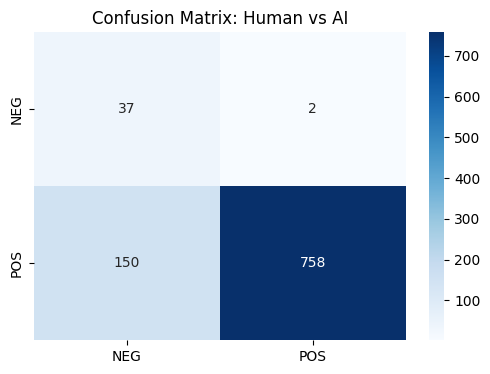

In [4]:
#setup classifier and sample 100 rows
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True)
df_sample = df_final.sample(1000, random_state=42).copy()

#map ratings and run sentiments
df_sample['rating_label'] = df_sample['reviews.rating'].map({1:'NEGATIVE', 2:'NEGATIVE', 3:'NEUTRAL', 4:'POSITIVE', 5:'POSITIVE'})
df_sample = df_sample.dropna(subset=['rating_label'])
texts = df_sample['reviews.text'].fillna("").tolist()
predictions = classifier(texts, batch_size=16)
df_sample['ai_sentiment'] = [p['label'].upper() for p in predictions]

#normalization and bulletproof comparison
df_sample['is_credible'] = df_sample['rating_label'] == df_sample['ai_sentiment']

#evaluation Report (Accuracy, Precision, Recall, F1)
print("MODEL EVALUATION REPORT")
print(classification_report(df_sample['rating_label'], df_sample['ai_sentiment'], labels=['NEGATIVE', 'POSITIVE']))

#graphical representation: Confusion Matrix
cm = confusion_matrix(df_sample['rating_label'], df_sample['ai_sentiment'], labels=['NEGATIVE', 'POSITIVE'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NEG', 'POS'], yticklabels=['NEG', 'POS'])
plt.title('Confusion Matrix: Human vs AI')
plt.show()

Apply on full data set & 'ai_sentiment' & 'is-credible' columns

In [5]:
#apply the rating map to the FULL dataset
rating_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df_final['rating_label'] = df_final['reviews.rating'].map(rating_map)

#run the classifier on the FULL text column
texts = df_final['reviews.text'].fillna("").tolist()
predictions = classifier(texts, batch_size=32) 

#create the 'ai_sentiment' and 'is_credible' columns
df_final['ai_sentiment'] = [p['label'] for p in predictions]
df_final['is_credible'] = (
    df_final['rating_label'].str.upper() == df_final['ai_sentiment'].str.upper()
)

#we filter: keep only the credible ones for Model 2 and 3
df_credible_all = df_final[df_final['is_credible'] == True].copy()

print(f"Total reviews processed: {len(df_final)}")
print(f"Total credible reviews kept: {len(df_credible_all)}")

df_credible_all.head()

Total reviews processed: 41291
Total credible reviews kept: 33950


,name,primaryCategories,reviews.text,reviews.title,reviews.rating,rating_label,ai_sentiment,is_credible
2,amazonbasics aaa performance alkaline batterie...,Health & Beauty,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5.0,Positive,POSITIVE,True
3,amazonbasics aaa performance alkaline batterie...,Health & Beauty,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5.0,Positive,POSITIVE,True
4,amazonbasics aaa performance alkaline batterie...,Health & Beauty,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5.0,Positive,POSITIVE,True
5,amazonbasics aaa performance alkaline batterie...,Health & Beauty,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,5.0,Positive,POSITIVE,True
7,amazonbasics aaa performance alkaline batterie...,Health & Beauty,Well if you are looking for cheap non-recharge...,... batteries that last quite a while then the...,5.0,Positive,POSITIVE,True


## Model 2: 

K-MEANS: TfidfVectorizer // Normalizate

In [6]:
#combine name and category to create a 'super-feature'
df_final['clustering_text'] = df_final['name'].fillna('') + " " + df_final['primaryCategories'].fillna('')

#optimization n-grams
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), max_features=3000)
X_optimized = vectorizer.fit_transform(df_final['clustering_text'])

#re-run k-means with 5 clusters 
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
df_final['meta_cluster'] = kmeans.fit_predict(X_optimized)

#check the new distribution
print(df_final['meta_cluster'].value_counts().sort_index())

meta_cluster
0    15227
1    11009
2     9242
3     3287
4     2526
Name: count, dtype: int64


In [7]:
#see the top 3 most common product names in each cluster to understand what they represent
for i, group in df_final.groupby('meta_cluster'):
    print(f"\n Cluster {i}:")
    print(group['name'].value_counts().head(3))


 Cluster 0:
name
amazon kindle paperwhite  ebook reader  4 gb  6 monochrome paperwhite  touchscreen  wifi  black    2927
allnew fire hd 8 tablet 8 hd display wifi 16 gb  includes special offers black                     2369
fire kids edition tablet 7 display wifi 16 gb pink kidproof case                                   1676
Name: count, dtype: int64

 Cluster 1:
name
fire tablet 7 display wifi 8 gb  includes special offers magenta    10769
fire tablet 7 display wifi 8 gb  includes special offers black        240
Name: count, dtype: int64

 Cluster 2:
name
amazonbasics aaa performance alkaline batteries 36 count                       7748
amazonbasics aa performance alkaline batteries 48 count  packaging may vary    1494
Name: count, dtype: int64

 Cluster 3:
name
echo whiteecho white    3287
Name: count, dtype: int64

 Cluster 4:
name
amazon fire tvamazon fire tv    2526
Name: count, dtype: int64


Naming and see top products

In [8]:
#determinate the names of clausters
cluster_names = {
    0: "Kindle & accessories",
    1: "Tablets",
    2: "Batteries",
    3: "Smart Home & Echo",
    4: "Entertainment & Fire TV",
}
#map the dictionary to create a human-readable column
df_final['meta_category_name'] = df_final['meta_cluster'].map(cluster_names)

#credible reviews only
df_ready = df_final[df_final['is_credible'] == True].copy()

#check if the mapping worked
print(df_ready[['name', 'meta_category_name']].head())

                                                name meta_category_name
2  amazonbasics aaa performance alkaline batterie...          Batteries
3  amazonbasics aaa performance alkaline batterie...          Batteries
4  amazonbasics aaa performance alkaline batterie...          Batteries
5  amazonbasics aaa performance alkaline batterie...          Batteries
7  amazonbasics aaa performance alkaline batterie...          Batteries


## Model 3:

BART: Initialize the Transformer & Compile text

In [ ]:
#1.setup: load the BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

#2.logic: the precise article function
def generate_blog_post(category_name, data):
    #mining: Group by name and filter for confidence (>10 reviews)
    stats = data.groupby('name')['reviews.rating'].agg(['mean', 'count'])
    stats = stats[stats['count'] > 10]
    
    if stats.empty: return "Not enough data for this category."
    
    #logic: Identify Top 3 and the absolute Worst 1
    top_3 = stats.sort_values(by='mean', ascending=False).head(3).index.tolist()
    worst = stats.sort_values(by='mean', ascending=True).index[0]
    
    #context: Structure the Pros and Cons for the AI
    pros = f"In the {category_name} category, we highly recommend {', '.join(top_3)}. "
    cons = f"However, avoid the {worst} due to low satisfaction scores."

    #execution: Generate the clean summary
    inputs = tokenizer(f"{pros} {cons}"[:1024], return_tensors="pt", truncation=True)
    summary_ids = model.generate(
        inputs["input_ids"], 
        num_beams=4, 
        max_length=150, 
        repetition_penalty=3.0, 
        early_stopping=True
    )
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# 3.execution
for cat in df_ready['meta_category_name'].unique():
    print(f"WRITING BLOG POST FOR: {cat}")
    article = generate_blog_post(cat, df_ready[df_ready['meta_category_name'] == cat])
    print(f"Result: {article}")
    print("-" * 60)

Please make sure the generation config includes `forced_bos_token_id=0`. 
Loading weights: 100%|██████████| 511/511 [00:00<00:00, 1779.35it/s, Materializing param=model.encoder.layers.11.self_attn_layer_norm.weight]   


WRITING BLOG POST FOR: Batteries
Result: In the Batteries category, we highly recommend amazonbasics aaa performance alkaline batteries 36 count and 48 count. However, avoid the amazonBasics aa performance alkalin batteries 48 count  packaging may vary due to low satisfaction scores. We have rated these batteries as 'excellent' for their battery life.
------------------------------------------------------------
WRITING BLOG POST FOR: Kindle & accessories
Result: Kindle voyage ereader 6 highresolution display 300 ppi with adaptive builtin light pagepress sensors free 3g  wifi. amazon fire hd 8 8in tablet 16gb black b018szt3bk 6th gen 2016 android, amazon 9w powerfast official oem usb charger and power adapter for fire tablets and kindle ereaders. avoid the amazon echo 1st generationcertified colorwhite free shipping due to low satisfaction scores.
------------------------------------------------------------
WRITING BLOG POST FOR: Tablets
Result: In the Tablets category, we highly recomm

## Website

In [10]:
df_ready.to_csv('final_dashboard_data.csv', index=False)